# Fractal Mountains

## Install required packages

In [89]:
!pip install numpy moderngl pillow
import numpy as np
import moderngl
import numpy as np
from PIL import Image
from IPython.display import Image as IPyImage
import io

In [90]:

n_iters = 1 # @param {type:"slider", min:0, max:5, step:1}
points_per_axis = 2 ** n_iters + 1
vertex_heights = np.full((points_per_axis, points_per_axis), -1, dtype=float)
vertex_heights

array([[-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.]])

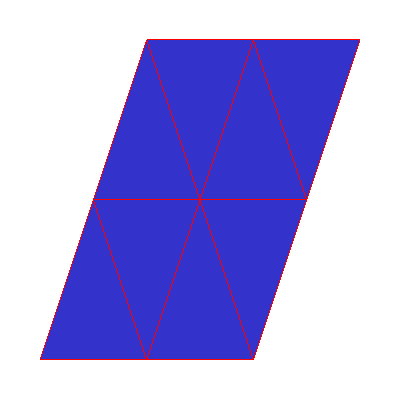

In [94]:
def load_shader(shader_path):
    """Load shader source from a file."""
    with open(shader_path, 'r') as f:
        return f.read()

def render_grid(vertex_heights: np.ndarray):
    """
    Renders the height map from directly above using raw WebGL commands via ModernGL.
    Grid is adjusted to show equilateral triangles in a rhombic pattern.
    """

    width = len(vertex_heights)
    ctx = moderngl.create_standalone_context()
    
    # Load shaders from files
    vertex_shader = load_shader('vertex.glsl')
    fragment_shader = load_shader('fragment.glsl')
    wire_fragment_shader = load_shader('wire_fragment.glsl')
    
    program = ctx.program(
        vertex_shader=vertex_shader,
        fragment_shader=fragment_shader,
    )

    # Set the width uniform
    program['width'] = width

    wire_program = ctx.program(
        vertex_shader=vertex_shader,
        fragment_shader=wire_fragment_shader,
    )

    # Set the width uniform for wire program too
    wire_program['width'] = width
    
    # Generate vertex data
    vertices = []
    indices = []
    
    # Create vertices - now just passing raw x_i, y_i, z values
    for x_i in range(width):
        for y_i in range(width):
            z = vertex_heights[x_i][y_i]
            vertices.extend([float(x_i), float(y_i), z])
    
    # Create triangles (unchanged)
    for x_i in range(width - 1):
        for y in range(width - 1):
            i = x_i * width + y
            indices.extend([i, i + width + 1, i + width])  # Bottom triangle
            indices.extend([i, i + 1, i + width + 1])      # Top triangle
    
    vertices = np.array(vertices, dtype='f4')
    indices = np.array(indices, dtype='i4')
    
    vbo = ctx.buffer(vertices.tobytes())
    ibo = ctx.buffer(indices.tobytes())
    
    vao = ctx.vertex_array(
        program,
        [(vbo, '3f', 'raw_position')],
        ibo
    )
    
    size = 400
    fbo = ctx.framebuffer(
        color_attachments=[ctx.texture((size, size), 4)]
    )
    
    fbo.use()
    ctx.clear(1.0, 1.0, 1.0, 1.0)
    
    vao.render()
    
    wire_vao = ctx.vertex_array(
        wire_program,
        [(vbo, '3f', 'raw_position')],
        ibo
    )
    
    ctx.wireframe = True
    wire_vao.render()
    
    image = Image.frombytes('RGBA', fbo.size, fbo.read(components=4))
    img_byte_arr = io.BytesIO()
    image.save(img_byte_arr, format='PNG')
    img_byte_arr = img_byte_arr.getvalue()
    
    return IPyImage(img_byte_arr)

render_grid(vertex_heights)